In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
X, y = fetch_california_housing(return_X_y=True)
X[:5], y[:5]

(array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
          1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
          3.78800000e+01, -1.22230000e+02],
        [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
          9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
          3.78600000e+01, -1.22220000e+02],
        [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
          1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
          3.78500000e+01, -1.22240000e+02],
        [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
          1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
          3.78500000e+01, -1.22250000e+02],
        [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
          1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
          3.78500000e+01, -1.22250000e+02]]),
 array([4.526, 3.585, 3.521, 3.413, 3.422]))

In [4]:
len(X), len(y)


(20640, 20640)

In [5]:
len(X[0])

8

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
#Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [7]:
# model
class Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [8]:
# mini-batch training
def mini_batch_train(model, train_loader, optimizer, loss_fn):
    mini_batch_losses = []
    for x_batch, y_batch in train_loader:
        model.train()
        # step 1 前向计算预测值
        yhat = model(x_batch)
        # step 2 计算损失
        mini_batch_loss = loss_fn(yhat, y_batch)
        # step 3 计算梯度
        mini_batch_loss.backward()
        # step 4 更新参数
        optimizer.step()
        # 清空梯度
        optimizer.zero_grad()
        # 记录损失
        mini_batch_losses.append(mini_batch_loss.item())
    
    return np.mean(mini_batch_losses)

In [9]:
# 测试
def mini_batch_val(model, test_loader, optimizer, loss_fn):
    mini_batch_losses = []
    for x_batch, y_batch in test_loader:
        # 置为验证状态
        model.eval()
        # Step 1 - 前向计算预测值
        yhat = model(x_batch)
        # Step 2 - 计算损失
        mini_batch_loss = loss_fn(yhat, y_batch)
        mini_batch_losses.append(mini_batch_loss.item())
    
    return np.mean(mini_batch_losses)

In [10]:
# 训练
def train(model, train_loader, test_loader, optimizer, loss_fn, epochs):
    # 指定随机数种子，可以再现数据
    np.random.seed(23)
    torch.manual_seed(23)

    # 循环轮数计数
    total_epochs = 0
    # 记录训练和验证损失
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # 训练
        model.train()
        total_epochs += 1
        train_loss = mini_batch_train(model, train_loader, optimizer, loss_fn)
        train_losses.append(train_loss)
        # 验证
        with torch.no_grad():
            val_loss = mini_batch_val(model, test_loader, optimizer, loss_fn)
            val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    
    return train_losses, val_losses

In [11]:
model = Regression()
loss = nn.MSELoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 100
train_losses, val_losses = train(model, train_loader, test_loader, optimizer, loss, epochs)


c:\Users\CuiShuning\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, train_loss: 3.7837, val_loss: 1.3388
Epoch 2/100, train_loss: 1.8150, val_loss: 1.5369
Epoch 3/100, train_loss: 1.4955, val_loss: 1.3536
Epoch 4/100, train_loss: 1.4134, val_loss: 1.3307
Epoch 5/100, train_loss: 1.3978, val_loss: 1.3144
Epoch 6/100, train_loss: 1.4142, val_loss: 1.3161
Epoch 7/100, train_loss: 1.4113, val_loss: 1.3508
Epoch 8/100, train_loss: 1.3980, val_loss: 1.3226
Epoch 9/100, train_loss: 1.4073, val_loss: 1.3623
Epoch 10/100, train_loss: 1.3783, val_loss: 1.3075
Epoch 11/100, train_loss: 1.3905, val_loss: 1.3907
Epoch 12/100, train_loss: 1.3729, val_loss: 1.3064
Epoch 13/100, train_loss: 1.3826, val_loss: 1.3070
Epoch 14/100, train_loss: 1.3703, val_loss: 1.3313
Epoch 15/100, train_loss: 1.3665, val_loss: 1.3079
Epoch 16/100, train_loss: 1.3613, val_loss: 1.3173
Epoch 17/100, train_loss: 1.3591, val_loss: 1.3214
Epoch 18/100, train_loss: 1.3618, val_loss: 1.3361
Epoch 19/100, train_loss: 1.3588, val_loss: 1.3051
Epoch 20/100, train_loss: 1.3601, val_lo

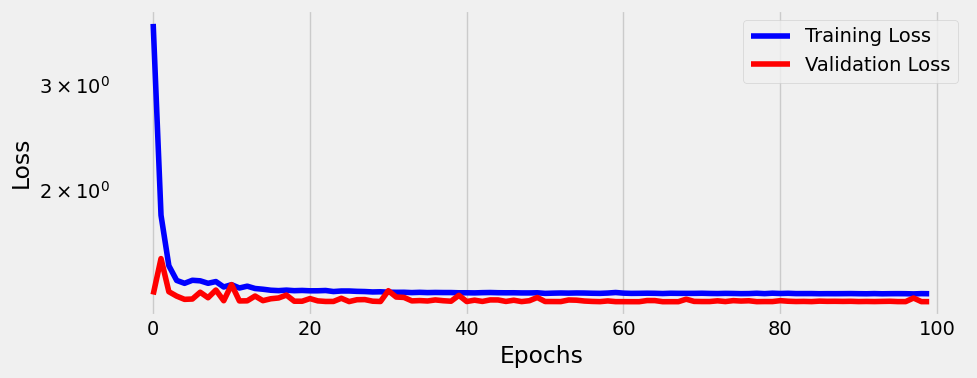

In [12]:
plt.style.use('fivethirtyeight')
def plot_losses():
    fig = plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Training Loss', c='b')
    plt.plot(val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

fig=plot_losses()

In [13]:
test_data, test_target = next(iter(test_loader))

In [14]:
test_data.shape, test_target.shape

(torch.Size([16, 8]), torch.Size([16]))

In [15]:
model.eval()
for i in range(16):
    yhat = model(test_data[i])
    print(f"Predicted value: {yhat.item():.4f}, Actual value: \
          {test_target[i].item():.4f}")
model.train()

Predicted value: 2.0473, Actual value:           2.0580
Predicted value: 2.0412, Actual value:           0.7330
Predicted value: 2.0412, Actual value:           0.6720
Predicted value: 2.0432, Actual value:           0.8190
Predicted value: 2.0554, Actual value:           2.4890
Predicted value: 2.0472, Actual value:           2.7110
Predicted value: 2.0611, Actual value:           1.3510
Predicted value: 2.0665, Actual value:           3.6170
Predicted value: 2.0456, Actual value:           2.0710
Predicted value: 2.0735, Actual value:           1.5320
Predicted value: 2.0597, Actual value:           0.7130
Predicted value: 2.0565, Actual value:           2.3560
Predicted value: 2.0893, Actual value:           2.1800
Predicted value: 2.0378, Actual value:           2.5980
Predicted value: 2.0360, Actual value:           2.1420
Predicted value: 2.0419, Actual value:           0.9380


Regression(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)